# This is an exmple for 3D EDSR training in micro-CT rock images
## Step 1: Creating training/testing images - mini data 

In [8]:
#
#generate mini LR data
from skimage import io
count1=1
img1 = io.imread('.\\Core1_Subvol1_LR.tif.tif')
for z in range(15,210,15):
    for y in range(15,210,15):
        for x in range(15,210,15):
            if count1<25:
                img = img1[z-15:z+15,y-15:y+15,x-15:x+15]
                io.imsave('.\\Mini_data\\TRAIN\\LR\\' + str(count1)+'.tif',img)
                count1+=1
            elif 24<count1<31:
                img = img1[z-15:z+15,y-15:y+15,x-15:x+15]
                io.imsave('.\\Mini_data\\TEST\\LR\\' + str(count1)+'.tif',img)
                count1+=1
            else:
                break


In [11]:
#generate mini HR data
count1=1
img1 = io.imread('.\\Core1_Subvol1_HR.tif.tif')
for z in range(15*3,210*3,15*3):
    for y in range(15*3,210*3,15*3):
        for x in range(15*3,210*3,15*3):
            if count1<25:
                img = img1[z-15*3:z+15*3,y-15*3:y+15*3,x-15*3:x+15*3]
                io.imsave('.\\Mini_data\\TRAIN\\HR\\' + str(count1)+'.tif',img)
                count1+=1
            elif 24<count1<31:
                img = img1[z-15*3:z+15*3,y-15*3:y+15*3,x-15*3:x+15*3]
                io.imsave('.\\Mini_data\\TEST\\HR\\' + str(count1)+'.tif',img)
                count1+=1
            else:
                break

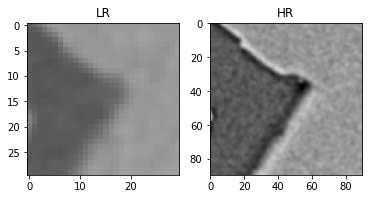

In [7]:
## view our mini data in 2D X-Y plane
%matplotlib inline
import matplotlib.pyplot as plt
LR = io.imread('.\\Mini_data\\TRAIN\\LR\\1.tif')
HR = io.imread('.\\Mini_data\\TRAIN\\HR\\1.tif')
f, axarr = plt.subplots(1,2)
axarr[0].imshow(LR[10,:,:],cmap='gray',vmin=0,vmax=255)
axarr[0].title.set_text('LR')
axarr[1].imshow(HR[30,:,:],cmap='gray',vmin=0,vmax=255)
axarr[1].title.set_text('HR')

## Step 2: Starting 3D EDSR training 

In [12]:
###main code for EDSR training
import argparse, os
import torch
import math, random
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from skimage import img_as_ubyte
from edsr_x3_3d import EDSR
from load_data import TrainDatasetFromFolder,TestDatasetFromFolder
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
from skimage import io
import cv2
from math import log10
import easydict
#Training settings
opt = easydict.EasyDict({
    "dir_train_data": '.\\Mini_data\\TRAIN\\',
    "dir_test_data": '.\\Mini_data\\TEST\\',
    "batchSize": 1,
    "nEpochs":1,
    "lr":1e-4,
    "step":10,
    "start_epoch":1,
    "momentum":0.9,
    "cuda":2,
    "threads":1,
})
device = torch.device("cuda:{}".format(opt.cuda))
def main():
    global opt, model
    cuda = opt.cuda
    if cuda and not torch.cuda.is_available():
        raise Exception("No GPU found, please run without --cuda")
    opt.seed = random.randint(1, 10000)
    print("Random Seed: ", opt.seed)
    torch.manual_seed(opt.seed)
    cudnn.benchmark = True
    print("===> Loading datasets")
    #load train/test data
    train_set = TrainDatasetFromFolder(opt.dir_train_data)
    test_set = TestDatasetFromFolder(opt.dir_test_data)
    training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, batch_size=opt.batchSize,shuffle=True)
    test_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.batchSize,shuffle=False)
    print("===> Building model")
    model = EDSR()
    criterion = nn.L1Loss(size_average=True)
    print("===> Setting GPU")
    model = model.to(device)
    criterion = criterion.to(device)

    print("===> Setting Optimizer")
    print("===> Training")
    for epoch in range(opt.start_epoch, opt.nEpochs + 1):
        optimizer = optim.Adam(model.parameters(), lr=opt.lr, betas=(0.9, 0.999))
        lr = adjust_learning_rate(optimizer, epoch-1)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        print("Epoch={}, lr={}".format(epoch, optimizer.param_groups[0]["lr"]))
        train(training_data_loader, optimizer, model, criterion, epoch)
        save_checkpoint(model, epoch)
        test(test_data_loader, optimizer, model, criterion, epoch)
    torch.save(model.state_dict(),'.\\3D_EDSR.pt')
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10"""
    lr = opt.lr * (0.1 ** (epoch // opt.step))
    return lr

def train(training_data_loader, optimizer, model, criterion, epoch):
    model.train()
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1],requires_grad=False)  #requires_grad=False
        input = input.to(device)
        target = target.to(device)
        sr = model(input)
        loss = criterion(sr, target)
        loss = loss.to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mse = torch.mean((sr - target) ** 2)
        psnr =  10 * math.log10(1.0 / torch.mean(mse))
        print("===> Epoch[{}]({}/{}): Loss: {:.10f} psnr:{:.10f}".format(epoch, iteration, len(training_data_loader), loss.item(),psnr))
def test(test_data_loader, optimizer, model, criterion, epoch):
    model.eval()
    for iteration, batch in enumerate(test_data_loader, 1):
        with torch.no_grad():
            input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
            input = input.to(device)
            target = target.to(device)
            sr = model(input)
            loss = criterion(sr, target)
            loss = loss.to(device)
            mse = torch.mean((sr - target) ** 2)
            psnr = 10 * math.log10(1.0 / torch.mean(mse))
            print("===> Epoch[{}]({}/{}): Loss: {:.10f} psnr: {:.10f}".format(epoch, iteration, len(test_data_loader), loss.item(), psnr))

if __name__ == "__main__":
    main()

Random Seed:  6619
===> Loading datasets
===> Building model
===> Setting GPU
===> Setting Optimizer
===> Training
Epoch=1, lr=0.0001
===> Epoch[1](1/24): Loss: 0.4768955112 psnr:5.7857065360
===> Epoch[1](2/24): Loss: 0.1452111453 psnr:13.0583221925
===> Epoch[1](3/24): Loss: 0.3825549781 psnr:7.5952080551
===> Epoch[1](4/24): Loss: 0.3800575137 psnr:7.7491114451
===> Epoch[1](5/24): Loss: 0.2554350495 psnr:10.8097856396
===> Epoch[1](6/24): Loss: 0.1502934843 psnr:13.9240382604
===> Epoch[1](7/24): Loss: 0.1651347429 psnr:13.1950535938
===> Epoch[1](8/24): Loss: 0.2101994753 psnr:11.9415619312
===> Epoch[1](9/24): Loss: 0.2196199000 psnr:11.6536052658
===> Epoch[1](10/24): Loss: 0.2286972255 psnr:11.6581214013
===> Epoch[1](11/24): Loss: 0.1712764502 psnr:13.1955771070
===> Epoch[1](12/24): Loss: 0.1484730840 psnr:14.3018400266
===> Epoch[1](13/24): Loss: 0.1163236201 psnr:15.2330982049
===> Epoch[1](14/24): Loss: 0.1401733458 psnr:14.8411343396
===> Epoch[1](15/24): Loss: 0.15267474

# Step3: Creating 3D validation LR image 

In [9]:
###validation mini data preparation
from skimage import io
#Generating validation sub-volumes to as the input data into trained EDSR
#step is the counts related to how many sclies in per sub-images in z axis.
img = io.imread('.\\Core1_Subvol2_LR.tif')
count = 1
step = 5
for i in range(0,2,step):
    img1 = img[i:i+step,:,:]
    io.imsave('.\\validation_data\\' + str(count) +'.tif',img1,imagej = True)
    count+=1

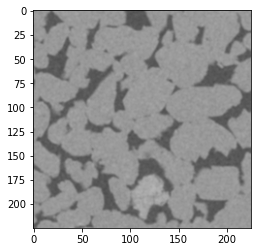

In [13]:
#view validation sub-images in 2D
%matplotlib inline
import matplotlib.pyplot as plt
validation_image = io.imread('.\\validation_data\\1.tif')
plt.imshow(validation_image[0,:,:],cmap='gray',vmin=0,vmax=255)
plt.show()

## Step4: Generate 3D Super resolution image 

In [ ]:
## generate 3D SR sub-images and stack sub-images to whole images
import argparse, os
import torch
import math, random
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from skimage import img_as_ubyte
from edsr_x3_3d import EDSR
from load_data import ValidationDatasetFromFolder
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
from skimage import io
import cv2
from math import log10
import easydict
#Training settings
opt = easydict.EasyDict({
    "dir_validation_data": '.\\validation_data\\',
    "batchSize": 1,
    "nEpochs":1,
    "cuda":2,
})
device = torch.device("cuda:{}".format(opt.cuda))
def main():
    global opt, model 
    cuda = opt.cuda
    if cuda and not torch.cuda.is_available():
        raise Exception("No GPU found, please run without --cuda")
    opt.seed = random.randint(1, 10000)
    print("Random Seed: ", opt.seed)
    torch.manual_seed(opt.seed)
    cudnn.benchmark = True
    print("===> Loading datasets")
    validation_set = ValidationDatasetFromFolder(opt.dir_validation_data)
    validation_data_loader = DataLoader(dataset=validation_set, num_workers=opt.threads, batch_size=opt.batchSize,shuffle=False)
    print("===> Building model")
    model = EDSR()
    print("===> Setting GPU")
    model = model.to(device)
    model_trained = torch.load('.\\3D_EDSR.pt')
    model.load_state_dict(model_trained,strict=False)
    validate(validate_data_loader, optimizer, model, criterion, epoch)
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10"""
    lr = opt.lr * (0.1 ** (epoch // opt.step))
    return lr

def validate(validate_data_loader, optimizer, model, criterion, epoch):
    model.eval()
    count = 1
    for iteration, batch in enumerate(test_data_loader, 1):
        with torch.no_grad():
            input, target = Variable(batch[0]), Variable(batch[0], requires_grad=False)
            input = input.to(device)
            input = target.to(device)
            sr = model(input)
            sr = sr.squeeze()
            sr = sr.cpu().numpy()
            sr = img_as_ubyte(np.clip(sr, 0, 1))
            sr = np.swapaxes(sr, 0, 1)
            sr = np.swapaxes(sr, 1, 2)
            io.imsave('.\\SR_subdata\\' + str(count) +'.tif',sr)
            count +=1
    stack_img3d(sr_img_root)
def stack_img3d(sr_img_root):
    list = []
    for i in range(1,num,1):
        img = io.imread('.\\SR_subdata\\' + str(i) +'.tif')
        list.append(img)
    volume3d = np.vstack(list)
    io.imsave('.\\SR.tif',volume3d)

if __name__ == "__main__":
    main()